In [1]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_sim.utils.MapData import MapData
from f1tenth_sim.utils.track_utils import RaceTrack, CentreLine


from f1tenth_sim.data_tools.general_plotting.plot_trajectory_analysis import plot_trajectory_analysis
from f1tenth_sim.data_tools.general_plotting.plot_raceline_tracking import plot_raceline_tracking

from f1tenth_sim.run_scripts.run_functions import *
import numpy as np


if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


## TODOs
- Set up global parameters for data generation and plotting.

# Generate Data

In [11]:
from f1tenth_sim.classic_racing.GlobalPurePursuit import GlobalPurePursuit

test_id = "mu70"
planner = GlobalPurePursuit(test_id, False, planner_name="FullStackPP")
test_full_stack_all_maps(planner, test_id)

plot_trajectory_analysis(planner.name, test_id)
plot_raceline_tracking(planner.name, test_id)

Testing on aut...
0 :: 501 LAP COMPLETE: Time: 20.04, Progress: 99.6
Testing on esp...
0 :: 1033 LAP COMPLETE: Time: 41.32, Progress: 99.6
Testing on gbr...
0 :: 890 LAP COMPLETE: Time: 35.60, Progress: 99.5
Testing on mco...
0 :: 823 LAP COMPLETE: Time: 32.92, Progress: 99.7
Vehicle name: FullStackPP
Planner name: FullStackPP
Analysing log: SimLog_esp_2.npy 
Analysing log: SimLog_gbr_2.npy 
Analysing log: SimLog_aut_3.npy 
Analysing log: SimLog_aut_1.npy 
Analysing log: SimLog_aut_2.npy 
Analysing log: SimLog_gbr_3.npy 
Analysing log: SimLog_esp_3.npy 
Analysing log: SimLog_esp_1.npy 
Analysing log: SimLog_gbr_1.npy 
Analysing log: SimLog_aut_4.npy 
Analysing log: SimLog_gbr_4.npy 
Analysing log: SimLog_esp_0.npy 
Analysing log: SimLog_mco_0.npy 
Analysing log: SimLog_aut_0.npy 
Analysing log: SimLog_esp_4.npy 
Analysing log: SimLog_gbr_0.npy 


In [12]:
from f1tenth_sim.mapless_racing.FollowTheGap import FollowTheGap
test_id = "Std"
planner = FollowTheGap(test_id)
test_mapless_all_maps(planner, test_id)

plot_trajectory_analysis(planner.name, test_id)
plot_raceline_tracking(planner.name, test_id)

Testing on aut...
0 :: 173 COLLISION: Time: 6.92, Progress: 33.2
Testing on esp...
0 :: 1144 LAP COMPLETE: Time: 45.76, Progress: 99.6
Testing on gbr...
0 :: 984 LAP COMPLETE: Time: 39.36, Progress: 99.5
Testing on mco...
0 :: 877 LAP COMPLETE: Time: 35.08, Progress: 99.6
Vehicle name: FollowTheGap
Planner name: FollowTheGap
Analysing log: SimLog_esp_2.npy 
Analysing log: SimLog_gbr_9.npy 
Analysing log: SimLog_mco_4.npy 
Analysing log: SimLog_mco_3.npy 
Analysing log: SimLog_aut_8.npy 
Analysing log: SimLog_mco_1.npy 
Analysing log: SimLog_esp_7.npy 
Analysing log: SimLog_gbr_2.npy 
Analysing log: SimLog_aut_3.npy 
Analysing log: SimLog_gbr_5.npy 
Analysing log: SimLog_gbr_7.npy 
Analysing log: SimLog_esp_8.npy 
Analysing log: SimLog_gbr_8.npy 
Analysing log: SimLog_mco_9.npy 
Analysing log: SimLog_mco_5.npy 
Analysing log: SimLog_aut_9.npy 
Analysing log: SimLog_aut_1.npy 
Analysing log: SimLog_aut_2.npy 
Analysing log: SimLog_mco_2.npy 
Analysing log: SimLog_gbr_3.npy 
Analysing log

# Load Data

In [26]:

summary_df = pd.read_csv("Logs/Summary.csv")

planners = ['GlobalPlanPP', "GlobalPlanMPCC", "FollowTheGap", "EndToEnd"]
test_ids = ["mu90_steps4", "t2", "Std", "TD3_TAL_12_gbr"]
# test_ids = ["mu70", "t2", "Std", "TD3v1"]
neat_planner_names = ["Pure pursuit", "MPCC", "Follow the gap", "End-to-end"]
n_planners = len(planners)
# planner_colors = ["#F97F51", "#3B3B98", "#55E6C1"]
planner_colors = ["#F97F51", "#3B3B98", "#55E6C1", "#FFC300"]

map_list = ["aut", "esp", "gbr", "mco"]
n_laps = 5
frequency = 25


In [27]:
#TODO: This data should be formed into a single table and then saved to a csv file for later use.....
lap_dfs = []
for i, planner_name in enumerate(planners):
    for m, map_name in enumerate(map_list):
        for lap_n in range(n_laps):
            data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
            df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
            df.steer_a = df.steer_a * 180 / np.pi
            df.yaw = df.yaw * 180 / np.pi
            df.slip = df.slip.abs() * 180 / np.pi

            el_lengths = np.linalg.norm(np.diff(data[:, :2], axis=0), axis=1)
            s_old = np.insert(np.cumsum(el_lengths), 0, 0)
            s_interp = np.linspace(0, np.sum(el_lengths), 1000)
            x_interp = np.interp(s_interp, s_old, data[:, 0])
            y_interp = np.interp(s_interp, s_old, data[:, 1])
            interp_path = np.stack([x_interp, y_interp], axis=1)
            el_lengths = np.linalg.norm(np.diff(interp_path, axis=0), axis=1)
            psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(interp_path, el_lengths, False)
            kappa_original_s = np.interp(s_old, s_interp, kappa)
            df["curvature"] = np.abs(kappa_original_s) * 180 / np.pi
            # df["curvature"] = np.abs(kappa) * 180 / np.pi
            df["d_steer"] = df.steer_a.diff().abs() * frequency
            df["lap_n"] = lap_n
            df["planner"] = planner_name
            df["map_name"] = map_name

            # data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/TrackingAccuracy_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
            # # print(data[:4, :])
            # df["ct_error"] = np.abs(data[:, 1])
            # df["speed_error"] = np.abs(data[:, 4])
            # df["raceline_speed"] = np.abs(data[:, 5])
            lap_dfs.append(df)


lap_df = pd.concat(lap_dfs)
# lap_df.dropna(inplace=True)
lap_df.loc[lap_df["progress"] < 0.05, "speed_error"] = 0
lap_df.loc[lap_df["progress"] < 0.02, "curvature"] = 0
# print(lap_df.head())
print(f"Lap data shape: {lap_df.shape}, nPlanners: {lap_df.planner.nunique()}")


Lap data shape: (63933, 16), nPlanners: 4


In [15]:

results_df = summary_df.loc[summary_df.Vehicle.isin(planners)]
results_df = results_df.loc[results_df.TestID.isin(test_ids)]

times_df = results_df[['Vehicle', 'MapName', 'AvgTime']]
# print(times_df)
times_df = times_df.pivot(index="Vehicle", columns="MapName", values="AvgTime")
times_df.columns = times_df.columns.str.upper()
times_df.rename(index=dict(zip(planners, neat_planner_names)), inplace=True)
print(times_df)

times_df.to_latex(f"{save_path}benchmark_laptimes.tex", float_format="%.2f")


MapName             AUT      ESP     GBR     MCO
Vehicle                                         
End-to-end      19.9440  44.5680  39.800  36.576
Follow the gap  19.1156  45.7400  39.328  35.028
MPCC            18.3600  42.2933  39.312  34.920
Pure pursuit    16.8760  36.1720  31.536  28.840


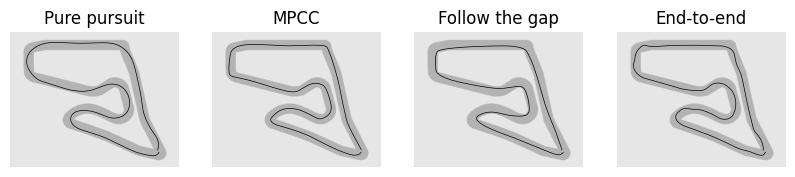

In [28]:
# Not actually used in results
plot_map = "aut"
map_data = MapData(plot_map)

fig, axs = plt.subplots(1, n_planners, figsize=(10, 2.5), sharey=True)
for i in range(n_planners):
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 2]

    xs, ys = map_data.xy2rc(df.x, df.y)
    plt.plot(xs, ys, color="black", linewidth=0.5)
    
    plt.axis('off')
    plt.title(neat_planner_names[i])

/tmp/ipykernel_14023/928026451.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


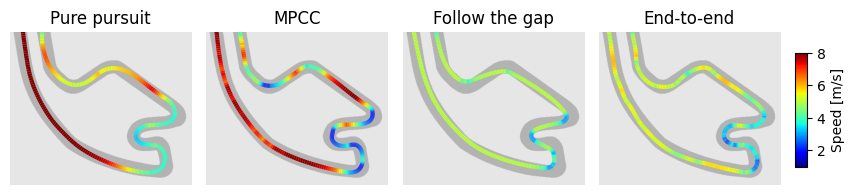

In [29]:
plot_map = "mco"
map_data = MapData(plot_map)

fig, axs = plt.subplots(1, n_planners, figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(n_planners):
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 4]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(3)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(600, 1110)
    plt.ylim(70, 500)
    plt.title(neat_planner_names[i])

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()

plt.savefig(f"{save_path}speed_trajectories_{map_name}.pdf", bbox_inches='tight')

In [30]:

lap_df_drop = lap_df[["slip", "curvature", "steer_a", "d_steer", "speed_error", "planner", "lap_n"]].copy()
lap_df_drop = lap_df[["speed_error", "steer_a", "d_steer", "curvature", "slip", "planner", "lap_n"]].copy()
lap_df_drop.steer_a = lap_df_drop.steer_a.abs()
lap_avg_view = lap_df_drop.groupby(["planner", "lap_n"])
lap_avg = lap_avg_view.mean()
lap_std = lap_avg_view.std()

mean_df = lap_avg.groupby("planner").mean()
mean_df.columns = ["Speed error [m/s]", "Steering angle [deg]", "Steering rate [deg/s]", "Curvature [rad/m]", "Slip [deg]"]
mean_df.rename(index=dict(zip(planners, neat_planner_names)), inplace=True)
mean_df = mean_df.T
mean_df = mean_df[["Pure pursuit", "Follow the gap", "End-to-end"]]
print(mean_df)

mean_df.to_latex(f"{save_path}benchmark_quality_measures.tex", float_format="%.2f")



planner                Pure pursuit  Follow the gap  End-to-end
Speed error [m/s]          0.000000        0.000000    0.000000
Steering angle [deg]       4.016625        2.895181    5.032798
Steering rate [deg/s]     15.861053       15.088158   42.953869
Curvature [rad/m]          9.260000        7.783071   10.656729
Slip [deg]                 3.078854        1.384187    2.456344


KeyError: 'raceline_speed'

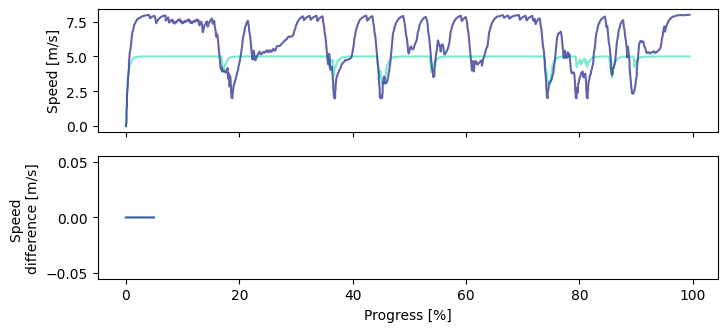

In [31]:
map_name = "esp"
raceline = "mu70"
rt = RaceTrack(map_name, raceline) # this is not providing the correct behaviour due to offset starts

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 3.5), sharex=True)
ax1.set_ylabel("Speed [m/s]")
ax2.set_ylabel("Speed \ndifference [m/s]")
ax2.set_xlabel("Progress [%]")

map_df = lap_df[lap_df["map_name"] == map_name]
map_df = map_df[map_df['lap_n'] == 1]

ss = rt.s_track / rt.s_track[-1] * 100
# ax1.plot(df["progress"]*100, df["raceline_speeds"], label="Raceline", color="black", linewidth=2, linestyle="--")
# ax1.plot(ss, rt.speeds, label="Raceline", color="black", linewidth=2, linestyle="--")
for i in range(2, -1, -1):
    df = map_df[map_df["planner"] == planners[i]]
    if i == 0:
        ax1.plot(df["progress"]*100, df["raceline_speed"], label="Raceline", color="black", linewidth=2, linestyle="--")

    ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.8, color=planner_colors[i])
    ax2.plot(df["progress"]*100, df["speed_error"], label=neat_planner_names[i], alpha=0.8, color=planner_colors[i])


ax1.grid(True)
ax2.grid(True)
ax1.set_ylim(2, 8.5)
ax2.set_ylim(-0.1, 3.2)
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.sca(ax1)
plt.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.3))

plt.tight_layout()
plt.savefig(f"{save_path}speed_comparison_{map_name}.pdf", bbox_inches='tight')

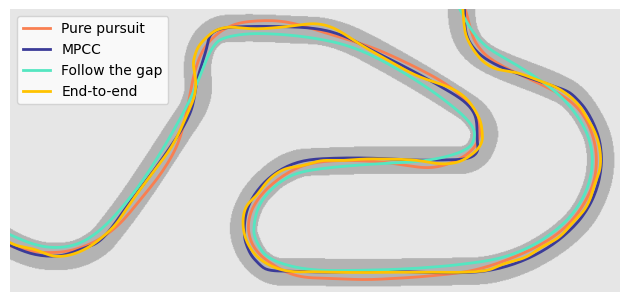

In [32]:
plot_map = "esp"
map_data = MapData(plot_map)

fig = plt.figure()
map_data.plot_map_img()
for i in range(n_planners):

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 1]

    xs, ys = map_data.xy2rc(df.x, df.y)
    plt.plot(xs, ys, linewidth=2, color=planner_colors[i], label=neat_planner_names[i])
    
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.xlim(660, 1480)
plt.ylim(50, 430)

plt.savefig(f"{save_path}path_comparison_{map_name}.pdf", bbox_inches='tight')



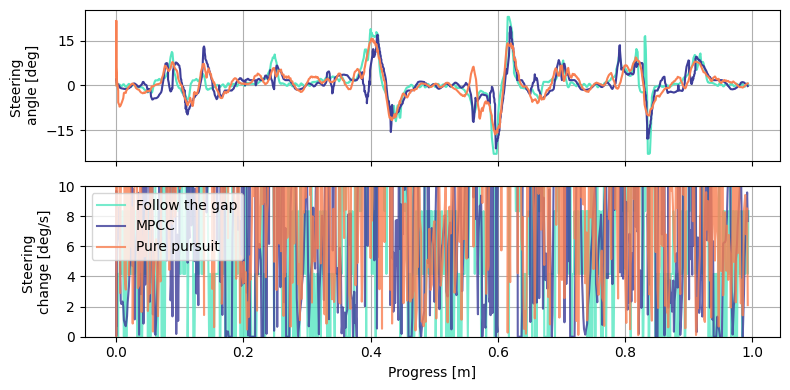

In [33]:
map_name = "gbr"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax1.set_ylabel("Steering \nangle [deg]")
ax2.set_ylabel("Steering \nchange [deg/s]")
ax2.set_xlabel("Progress [m]")

map_df = lap_df[lap_df["map_name"] == map_name]
map_df = map_df[map_df['lap_n'] == 0]

for i in range(2, -1, -1):
    df = map_df[map_df["planner"] == planners[i]]
    ax1.plot(df["progress"], df["steer_a"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i])

    ax2.plot(df["progress"], df["d_steer"], label=neat_planner_names[i], alpha=0.8, color=planner_colors[i])

ax1.grid(True)
ax2.grid(True)
ax2.set_ylim(0, 10)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.legend()

plt.tight_layout()
plt.savefig(f"{save_path}steering_comparison_{map_name}.pdf", bbox_inches='tight')

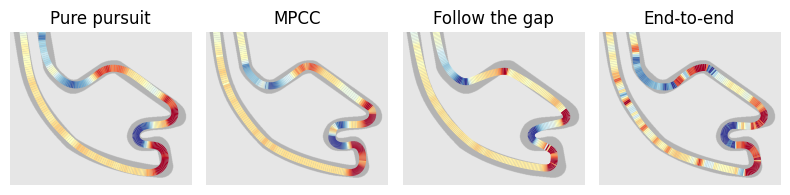

In [34]:
plot_map = "mco"
map_data = MapData(plot_map)

fig, axs = plt.subplots(1, n_planners, figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(n_planners):
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 4]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(-10, 10)
    lc = LineCollection(segments, cmap='RdYlBu', norm=norm)
    lc.set_array(df.steer_a.values)
    lc.set_linewidth(5)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(600, 1110)
    plt.ylim(70, 500)
    plt.title(neat_planner_names[i])


plt.tight_layout()

plt.savefig(f"{save_path}steering_trajectories_{map_name}.pdf", bbox_inches='tight')

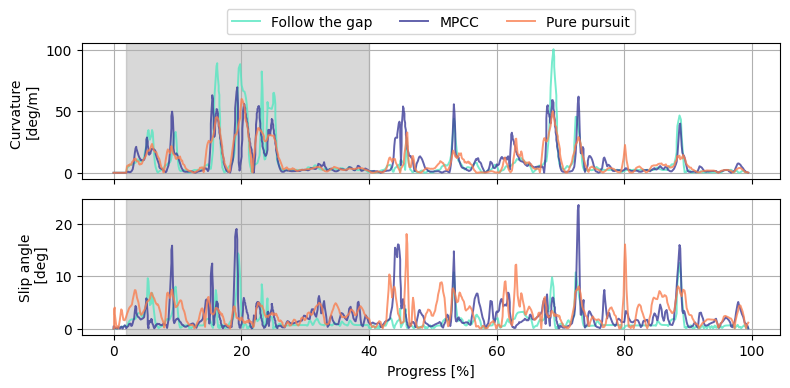

In [35]:
map_name = "mco"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax1.set_ylabel("Curvature \n[deg/m]")
ax2.set_ylabel("Slip angle\n [deg]")
ax2.set_xlabel("Progress [%]")

map_df = lap_df[lap_df["map_name"] == map_name]
map_df = map_df[map_df['lap_n'] == 4]

for i in [2, 1, 0]:
    df = map_df[map_df["planner"] == planners[i]]
    ax1.plot(df["progress"]*100, df["curvature"], linewidth=1.4, label=neat_planner_names[i], alpha=0.8, color=planner_colors[i])
    ax2.plot(df["progress"]*100, df["slip"].abs(), linewidth=1.4, label=neat_planner_names[i], alpha=0.8, color=planner_colors[i])

ax1.grid(True)
ax2.grid(True)

ax1.axvspan(2, 40, color='gray', alpha=0.3)
ax2.axvspan(2, 40, color='gray', alpha=0.3)

plt.sca(ax1)
plt.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.3))
plt.tight_layout()
plt.savefig(f"{save_path}curvature_comparison_{map_name}.pdf", bbox_inches='tight')

/tmp/ipykernel_14023/2432939003.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


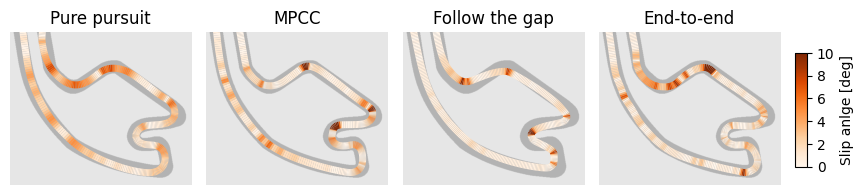

In [36]:
plot_map = "mco"
map_data = MapData(plot_map)

fig, axs = plt.subplots(1, n_planners, figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(n_planners):
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 4]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(0, 10)
    lc = LineCollection(segments, cmap='Oranges', norm=norm)
    lc.set_array(df.slip.values)
    lc.set_linewidth(5)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(600, 1110)
    plt.ylim(70, 500)
    plt.title(neat_planner_names[i])

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Slip anlge [deg]", ticks=[0, 2, 4, 6, 8, 10])
plt.tight_layout()

plt.savefig(f"{save_path}slip_trajectories_{map_name}.pdf", bbox_inches='tight')

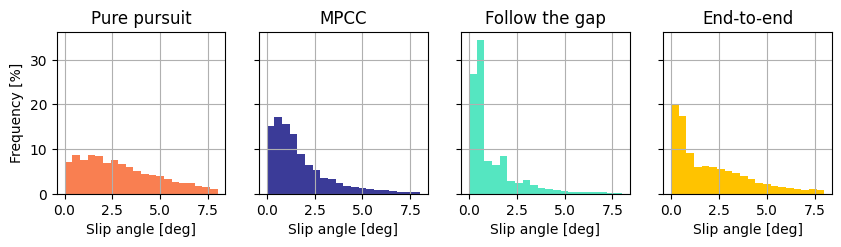

In [37]:
map_df = lap_df[lap_df["map_name"] == "gbr"]
fig, axs = plt.subplots(1, n_planners, figsize=(10, 2.1), sharey=True)
for i in range(n_planners):
    plt.sca(axs[i])
    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df['lap_n'] < 5]
    df = df.slip
    
    hist, edges = np.histogram(df, bins=20, range=(0, 8))
    freq = hist / float(hist.sum()) * 100
    width = np.diff(edges) # edges is bins
    plt.bar(edges[:-1], freq, width=width, align="edge", color=planner_colors[i])
    plt.xlabel("Slip angle [deg]")
    plt.title(neat_planner_names[i])
    plt.grid(True)

axs[0].set_ylabel("Frequency [%]")
plt.savefig(f"{save_path}slip_distributions.pdf", bbox_inches="tight")

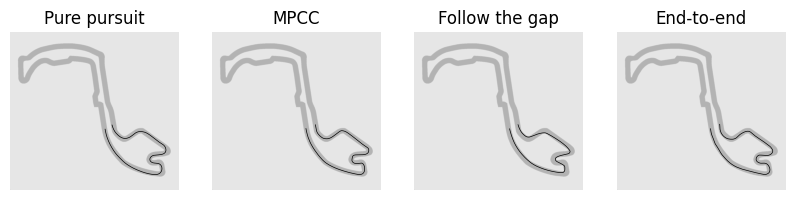

In [38]:
plot_map = "mco"
map_data = MapData(plot_map)

fig, axs = plt.subplots(1, n_planners, figsize=(10, 2.5), sharey=True)
for i in range(n_planners):
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 4]

    df = df[(df["progress"] > 0.02) & (df["progress"] < 0.4)]

    xs, ys = map_data.xy2rc(df.x, df.y)
    plt.plot(xs, ys, color="black", linewidth=0.5)
    
    plt.axis('off')
    plt.title(neat_planner_names[i])